Load MNIST data.

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt


(train_x, train_y), (test_x, test_y) = utils.processed_data()

A fuzzy classifier is trained on the original feature space.

Using TensorFlow backend.


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.0957 - categorical_accuracy: 0.8614 - val_loss: 0.0577 - val_categorical_accuracy: 0.9093
Epoch 2/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.0557 - categorical_accuracy: 0.9090 - val_loss: 0.0504 - val_categorical_accuracy: 0.9170
Epoch 3/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.0507 - categorical_accuracy: 0.9162 - val_loss: 0.0477 - val_categorical_accuracy: 0.9209
Epoch 4/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.0483 - categorical_accuracy: 0.9201 - val_loss: 0.0466 - val_categorical_accuracy: 0.9227
Epoch 5/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.0468 - categorical_accuracy: 0.9226 - val_loss: 0.0458 - val_categorical_accuracy: 0.9257
Epoch 6/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.0459 - categor

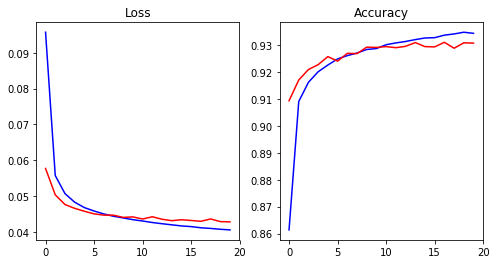

In [2]:
import keras
import keras.layers as layers
import keras.models as models
import keras.regularizers as regularizers
import keras.backend as K
from model import LogGaussMF


def train_baseline():
    model = keras.Sequential([
        layers.Reshape((784,), input_shape=(28,28)),
        LogGaussMF(10),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.0005),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")

    return model


model = train_baseline()

When the classifier is trained in the original feature space, mu and beta can be plotted as images in the original feature space. This will not work when convolutional layers are being used. Additionally, the images of mu and beta don't provide a lot of information.

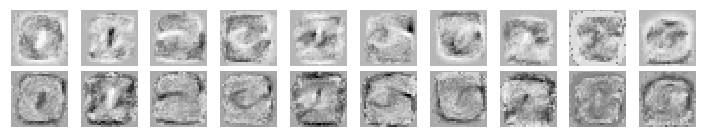

In [3]:
mu, beta = model.layers[-3].get_weights()

fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28,28), cmap="Greys", vmin=np.min(mu), vmax=np.max(mu))
    axes[1][i].imshow(beta[i,:].reshape(28,28), cmap="Greys", vmin=np.min(beta), vmax=np.max(beta))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The representatives for each class can be found by finding the training sample that maximizes the firing strength of the rule that corresponds to a specific class.

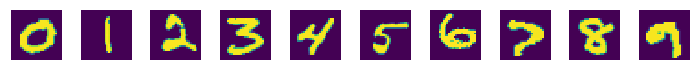

In [4]:
def find_representatives(model):
    pred_y = model.predict(train_x)
    
    repr_idxs = []
    for i in range(10):
        repr_idxs.append(np.argmax(pred_y[:,i]))
    
    return train_x[repr_idxs]


representatives = find_representatives(model)

fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i, image in enumerate(representatives):
    axes[i].imshow(image)
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The model is first analyzed using only the gradient of the input image. The images plotted below show that the the digits themselves have a relatively small gradient compared to the blank space around them.

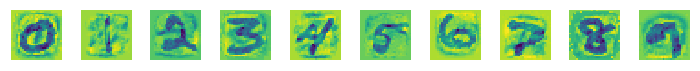

In [5]:
import innvestigate
from keras.models import Model


model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "gradient", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)


#medoids = 26438, 54614, 1299, 42186, 56856, 57814, 44801, 53334, 15115, 24825
    
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i, image in enumerate(representatives):
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
    
    analysis -= np.min(analysis)
    analysis /= np.max(analysis)
    
    cutoff = np.percentile(analysis.flatten(), 0)
    analysis *= (analysis > cutoff)

    axes[i].imshow(analysis)
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The model is analyzed using regular guided backprop. Here, the pixels with the highest relevance are the pixels of the digit itself, not the pixels around it.

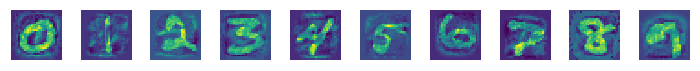

In [6]:
model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "guided_backprop", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)

    
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i, image in enumerate(representatives):
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
    
    analysis -= np.min(analysis)
    analysis /= np.max(analysis)
    
    cutoff = np.percentile(analysis.flatten(), 0)
    analysis *= (analysis > cutoff)

    axes[i].imshow(analysis)
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Finally, the model is analyzed using the custom relevance propagation technique developed in the Iris dataset notebook. The results are very similar to the gradient analysis method, where the highest relevance is placed on the empty pixels.

It appears that regular guided backprop will give the best results when analyzing the hybrid neural network.

The blank pixels likely have large relevance values because the value of mu is probably closer to the value in the image because those pixels are almost always zero.

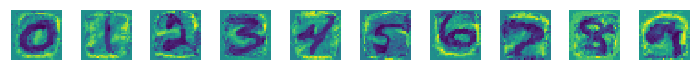

In [7]:
from innvestigate.analyzer import base
from innvestigate import layers as ilayers
from innvestigate.utils.keras import checks as kchecks
from innvestigate.utils.keras import graph as kgraph
from innvestigate.analyzer.gradient_based import GuidedBackpropReverseReLULayer


"""
The code below is taken from the iNNvestigate package and modified
to be used with the deep-fuzzy network hybrid.

The original source can be found at.
https://github.com/albermax/innvestigate/blob/master/innvestigate/analyzer/gradient_based.py
"""


class ReverseLogGaussMFLayer(kgraph.ReverseMappingBase):

    def __init__(self, layer, state):
        self.mu = layer.mu
        self.beta = layer.beta
        
        
    def reverse_fn(self, Xs, Ys, reversed_Ys):
        x = K.expand_dims(Xs, axis=0)
        x = 1 + K.square(x - self.mu)
        x = reversed_Ys * self.beta / x
        return K.sum(x, axis=1)
        

    def apply(self, Xs, Ys, reversed_Ys, reverse_state):
        return layers.Lambda(lambda x: self.reverse_fn(*x))(Xs + Ys + reversed_Ys)


class DNFISGuidedBackprop(base.ReverseAnalyzerBase):
    """Guided backprop analyzer.
    Applies the "guided backprop" algorithm to analyze the model.
    :param model: A Keras model.
    """

    def __init__(self, model, **kwargs):

        self._add_model_softmax_check()
        self._add_model_check(
            lambda layer: not kchecks.only_relu_activation(layer),
            "GuidedBackprop is only specified for "
            "networks with ReLU activations.",
            check_type="exception",
        )
        
        assert(isinstance(model.layers[-2], LogGaussMF))
        self.mu, self.beta = model.layers[-2].get_weights()

        super(DNFISGuidedBackprop, self).__init__(model, **kwargs)
        
        
    def _head_mapping(self, X):
        return ilayers.OnesLike()(X)
        

    def _create_analysis(self, *args, **kwargs):

        self._add_conditional_reverse_mapping(
            lambda layer: kchecks.contains_activation(layer, "relu"),
            GuidedBackpropReverseReLULayer,
            name="guided_backprop_reverse_relu_layer",
        )
        self._add_conditional_reverse_mapping(
            lambda layer: isinstance(layer, LogGaussMF),
            ReverseLogGaussMFLayer,
            name="reverse_log_gauss_mf",
        )

        return super(DNFISGuidedBackprop, self)._create_analysis(*args, **kwargs)
    
    
    # override original function with patched version
    def _handle_debug_output(self, debug_values):
    
        if self._reverse_check_min_max_values:
            indices = self._debug_tensors_indices["min"]
            tmp = debug_values[indices[0]:indices[1]]
            tmp = sorted([(self._reverse_tensors_mapping[i], v)
                          for i, v in enumerate(tmp)])
            print("Minimum values in tensors: "
                  "((NodeID, TensorID), Value) - {}".format(tmp))

            indices = self._debug_tensors_indices["max"]
            tmp = debug_values[indices[0]:indices[1]]
            tmp = sorted([(self._reverse_tensors_mapping[i], v)
                          for i, v in enumerate(tmp)])
            print("Maximum values in tensors: "
                  "((NodeID, TensorID), Value) - {}".format(tmp))

        if self._reverse_check_finite:
            indices = self._debug_tensors_indices["finite"]
            tmp = debug_values[indices[0]:indices[1]]
            nfinite_tensors = np.flatnonzero(np.asarray(tmp) > 0)

            if len(nfinite_tensors) > 0:
                nfinite_tensors = sorted([self._reverse_tensors_mapping[i]
                                          for i in nfinite_tensors])
                print("Not finite values found in following nodes: "
                      "(NodeID, TensorID) - {}".format(nfinite_tensors))

        if self._reverse_keep_tensors:
            indices = self._debug_tensors_indices["keep"]
            tmp = debug_values[indices[0]:indices[1]]
            # added: key=lambda x: x[0]
            tmp = sorted([(self._reverse_tensors_mapping[i], v)
                          for i, v in enumerate(tmp)], key=lambda x: x[0])
            self._reversed_tensors = tmp
            
            
model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
analyzer = DNFISGuidedBackprop(
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)

    
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i, image in enumerate(representatives):
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
    
    analysis -= np.min(analysis)
    analysis /= np.max(analysis)
    
    cutoff = np.percentile(analysis.flatten(), 0)
    analysis *= (analysis > cutoff)

    axes[i].imshow(analysis)
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

A neural network with a single convolutional layer is now trained for analysis.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.0539 - categorical_accuracy: 0.9123 - val_loss: 0.0293 - val_categorical_accuracy: 0.9523
Epoch 2/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.0247 - categorical_accuracy: 0.9601 - val_loss: 0.0185 - val_categorical_accuracy: 0.9690
Epoch 3/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.0168 - categorical_accuracy: 0.9736 - val_loss: 0.0145 - val_categorical_accuracy: 0.9749
Epoch 4/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.0130 - categorical_accuracy: 0.9788 - val_loss: 0.0120 - val_categorical_accuracy: 0.9786
Epoch 5/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.0108 - categorical_accuracy: 0.9825 - val_loss: 0.0117 - val_categorical_accuracy: 0.9804
Epoch 6/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.0093 - categor

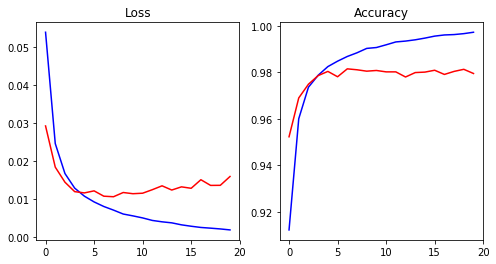

In [8]:
def train_cnn():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, 3, strides=1, activation="relu", padding="same"),
        layers.Flatten(),
        LogGaussMF(10),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.0005),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")

    return model


conv1_model = train_cnn()

Again, the three methods of analysis are compared here. In this example the results from the custom guided backprop implementation is much closer to the results of guided backprop, but still not better as will be shown later.

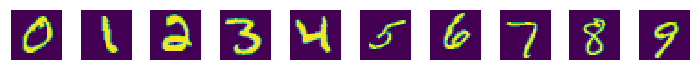

In [9]:
representatives = find_representatives(conv1_model)

fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i, image in enumerate(representatives):
    axes[i].imshow(image)
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

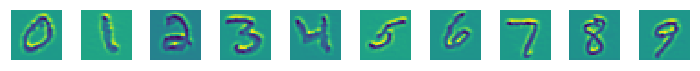

In [10]:
model_wo_softmax = Model(conv1_model.inputs, [conv1_model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "gradient", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)
    
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i, image in enumerate(representatives):
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
    
    analysis -= np.min(analysis)
    analysis /= np.max(analysis)
    
    cutoff = np.percentile(analysis.flatten(), 0)
    analysis *= (analysis > cutoff)

    axes[i].imshow(analysis)
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

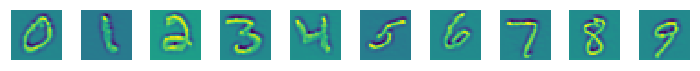

In [11]:
model_wo_softmax = Model(conv1_model.inputs, [conv1_model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "guided_backprop", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)
    
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i, image in enumerate(representatives):
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
    
    analysis -= np.min(analysis)
    analysis /= np.max(analysis)
    
    cutoff = np.percentile(analysis.flatten(), 0)
    analysis *= (analysis > cutoff)

    axes[i].imshow(analysis)
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

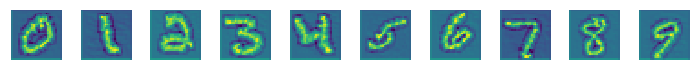

In [12]:
model_wo_softmax = Model(conv1_model.inputs, [conv1_model.layers[-2].output])
analyzer = DNFISGuidedBackprop(
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)
    
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i, image in enumerate(representatives):
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
    
    analysis -= np.min(analysis)
    analysis /= np.max(analysis)
    
    cutoff = np.percentile(analysis.flatten(), 0)
    analysis *= (analysis > cutoff)

    axes[i].imshow(analysis)
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The intermediate relevances are plotted along with the input image relevances for the custom backpropagation method. Only the top 10% of values are kept, the remainder are set to 0. The input layer images look okay, but the intermediate layer images are very noisy and useless in terms of interpretability.

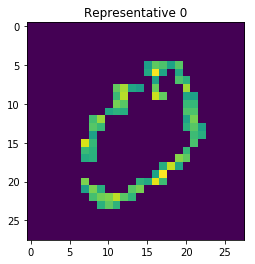

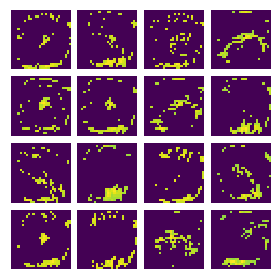

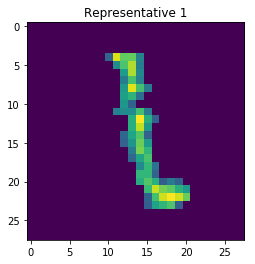

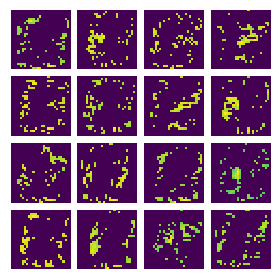

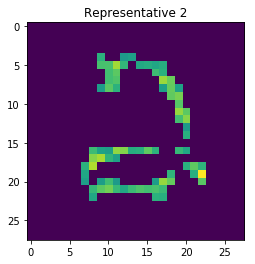

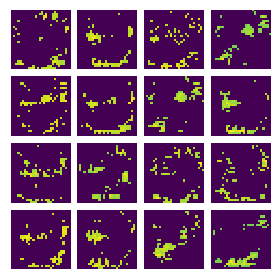

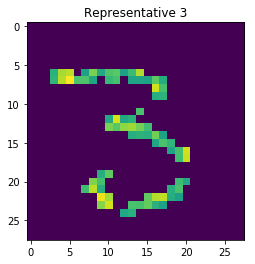

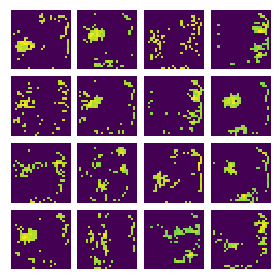

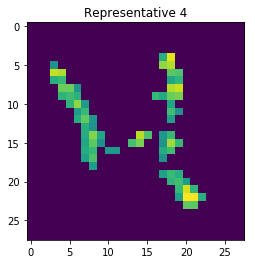

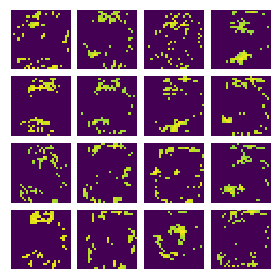

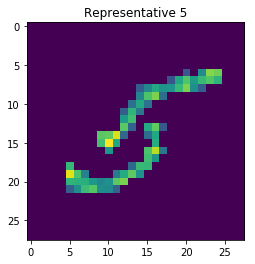

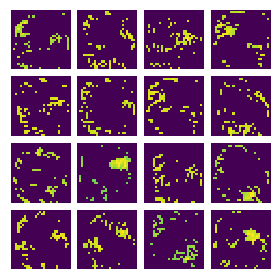

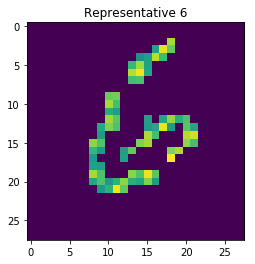

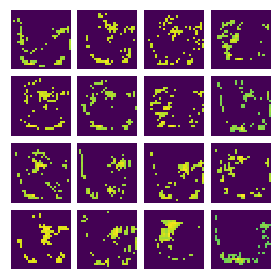

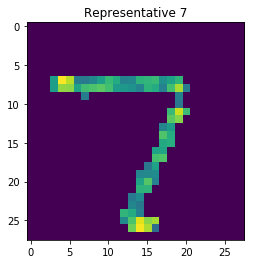

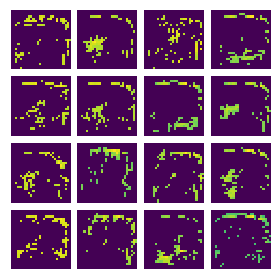

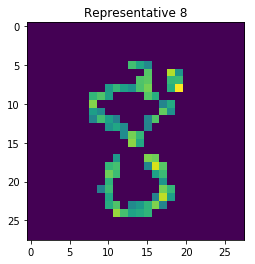

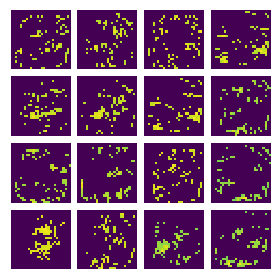

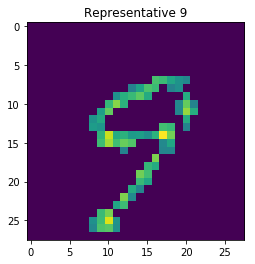

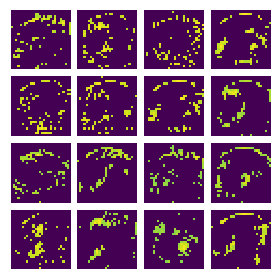

In [13]:
model_wo_softmax = Model(conv1_model.inputs, [conv1_model.layers[-2].output])
analyzer = DNFISGuidedBackprop(
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True,
    reverse_keep_tensors=True)


threshold = 90

for i, image in enumerate(representatives):
    
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
            
    cutoff = np.percentile(analysis.flatten(), threshold)
    analysis *= (analysis > cutoff)
    
    plt.figure()
    plt.imshow(analysis)
    plt.title("Representative {}".format(i))
    
    for idx, tensor in analyzer._reversed_tensors:
        if idx[0] == 1:
            fig, axes = plt.subplots(4, 4, figsize=(4,4))
            axes = axes.flatten()

            for j in range(16):
                analysis = tensor[...,j].squeeze()
                cutoff = np.percentile(analysis.flatten(), threshold)
                analysis *= (analysis > cutoff)
                axes[j].imshow(analysis)

            plt.setp(axes, xticks=[], yticks=[], frame_on=False)
            plt.tight_layout(h_pad=0, w_pad=0)

Traditional guided backprop gives much better results than the custom implementation. Shown below is are the images with no values masked. The cells after that show the images with only the top 90%, 95% and 97% relevance values.

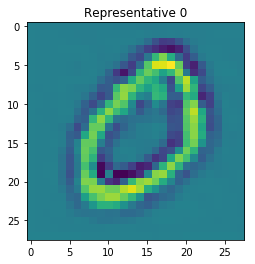

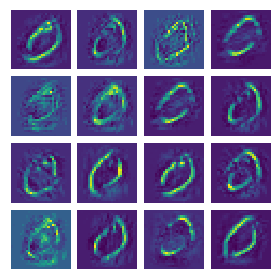

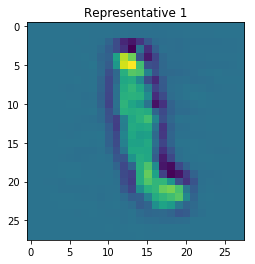

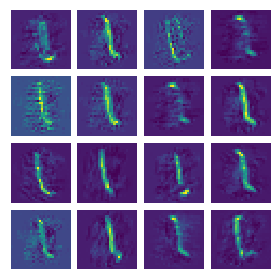

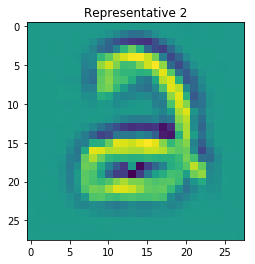

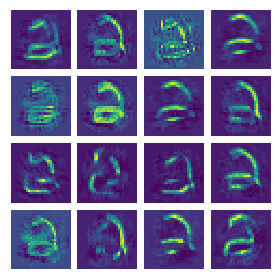

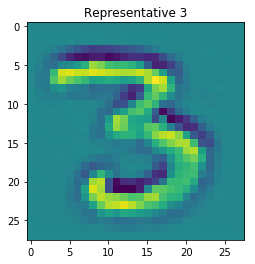

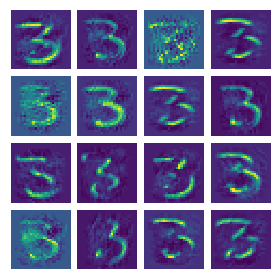

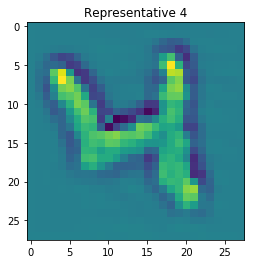

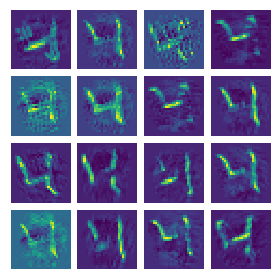

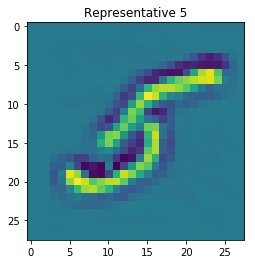

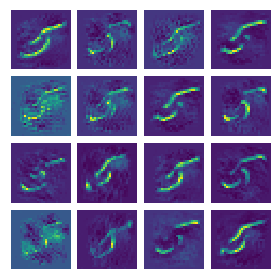

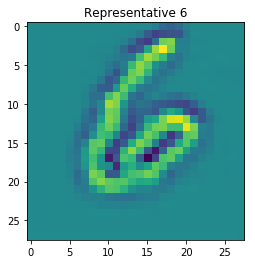

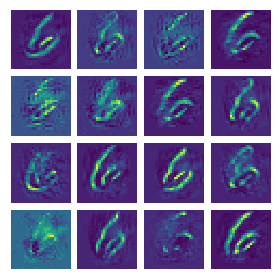

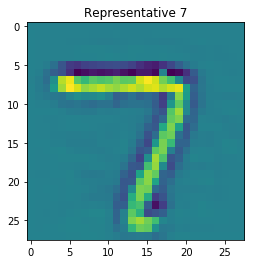

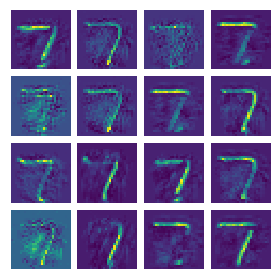

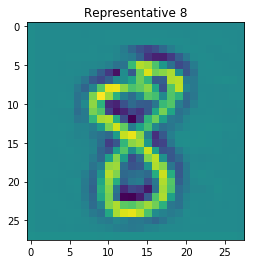

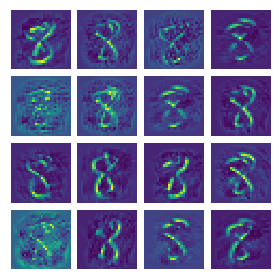

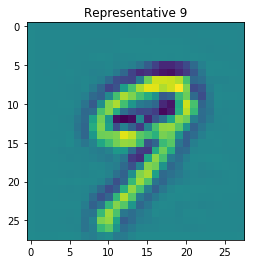

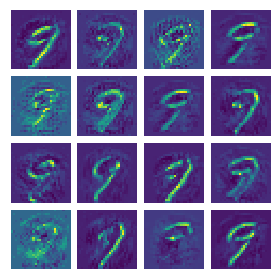

In [14]:
class GuidedBackpropFixed(innvestigate.analyzer.gradient_based.GuidedBackprop):
    # override original function with patched version
    def _handle_debug_output(self, debug_values):
    
        if self._reverse_check_min_max_values:
            indices = self._debug_tensors_indices["min"]
            tmp = debug_values[indices[0]:indices[1]]
            tmp = sorted([(self._reverse_tensors_mapping[i], v)
                          for i, v in enumerate(tmp)])
            print("Minimum values in tensors: "
                  "((NodeID, TensorID), Value) - {}".format(tmp))

            indices = self._debug_tensors_indices["max"]
            tmp = debug_values[indices[0]:indices[1]]
            tmp = sorted([(self._reverse_tensors_mapping[i], v)
                          for i, v in enumerate(tmp)])
            print("Maximum values in tensors: "
                  "((NodeID, TensorID), Value) - {}".format(tmp))

        if self._reverse_check_finite:
            indices = self._debug_tensors_indices["finite"]
            tmp = debug_values[indices[0]:indices[1]]
            nfinite_tensors = np.flatnonzero(np.asarray(tmp) > 0)

            if len(nfinite_tensors) > 0:
                nfinite_tensors = sorted([self._reverse_tensors_mapping[i]
                                          for i in nfinite_tensors])
                print("Not finite values found in following nodes: "
                      "(NodeID, TensorID) - {}".format(nfinite_tensors))

        if self._reverse_keep_tensors:
            indices = self._debug_tensors_indices["keep"]
            tmp = debug_values[indices[0]:indices[1]]
            # added: key=lambda x: x[0]
            tmp = sorted([(self._reverse_tensors_mapping[i], v)
                          for i, v in enumerate(tmp)], key=lambda x: x[0])
            self._reversed_tensors = tmp


model_wo_softmax = Model(conv1_model.inputs, [conv1_model.layers[-2].output])
analyzer = GuidedBackpropFixed(
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True,
    reverse_keep_tensors=True)


threshold = 0

for i, image in enumerate(representatives):
    
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
            
    cutoff = np.percentile(analysis.flatten(), threshold)
    analysis *= (analysis > cutoff)
    
    plt.figure()
    plt.imshow(analysis)
    plt.title("Representative {}".format(i))
    
    for idx, tensor in analyzer._reversed_tensors:
        if idx[0] == 1:
            fig, axes = plt.subplots(4, 4, figsize=(4,4))
            axes = axes.flatten()

            for j in range(16):
                analysis = tensor[...,j].squeeze()
                cutoff = np.percentile(analysis.flatten(), threshold)
                analysis *= (analysis > cutoff)
                axes[j].imshow(analysis)

            plt.setp(axes, xticks=[], yticks=[], frame_on=False)
            plt.tight_layout(h_pad=0, w_pad=0)

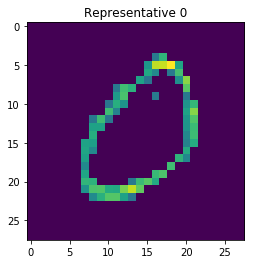

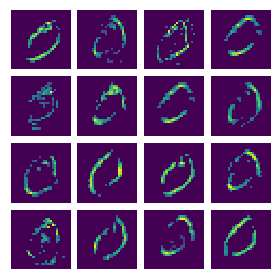

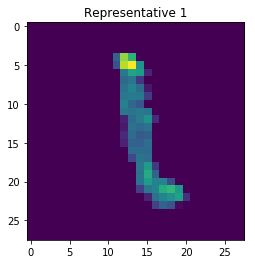

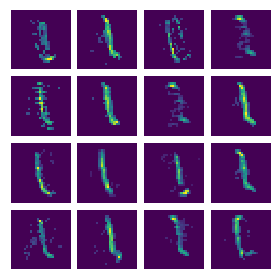

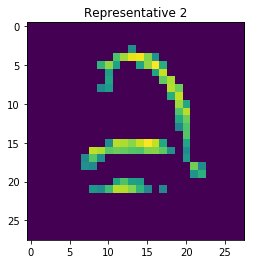

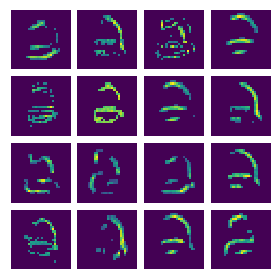

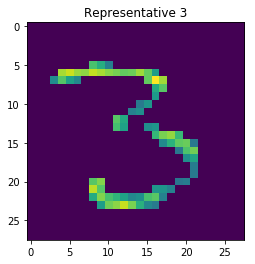

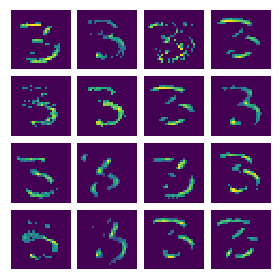

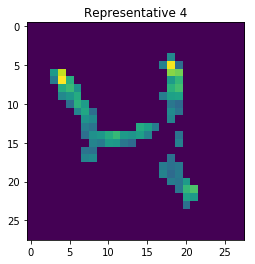

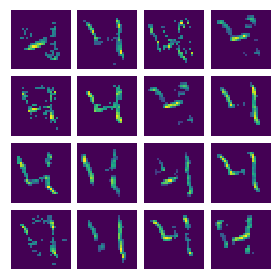

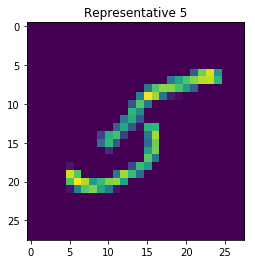

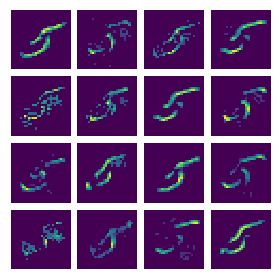

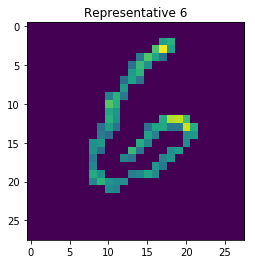

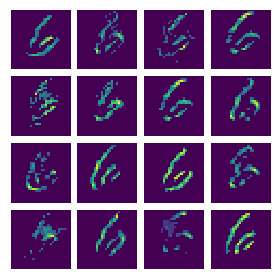

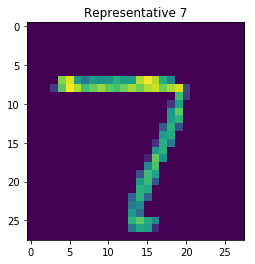

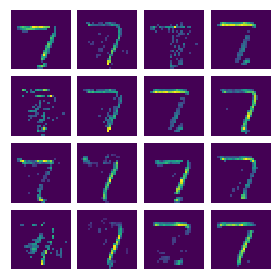

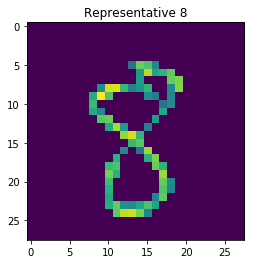

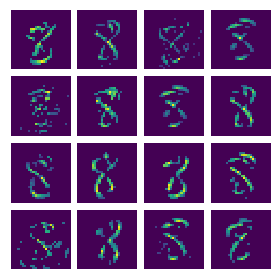

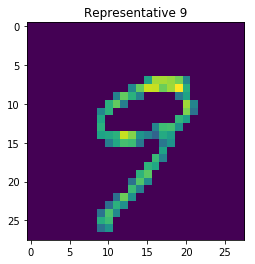

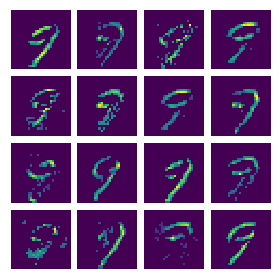

In [15]:
threshold = 90

for i, image in enumerate(representatives):
    
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
            
    cutoff = np.percentile(analysis.flatten(), threshold)
    analysis *= (analysis > cutoff)
    
    plt.figure()
    plt.imshow(analysis)
    plt.title("Representative {}".format(i))
    
    for idx, tensor in analyzer._reversed_tensors:
        if idx[0] == 1:
            fig, axes = plt.subplots(4, 4, figsize=(4,4))
            axes = axes.flatten()

            for j in range(16):
                analysis = tensor[...,j].squeeze()
                cutoff = np.percentile(analysis.flatten(), threshold)
                analysis *= (analysis > cutoff)
                axes[j].imshow(analysis)

            plt.setp(axes, xticks=[], yticks=[], frame_on=False)
            plt.tight_layout(h_pad=0, w_pad=0)

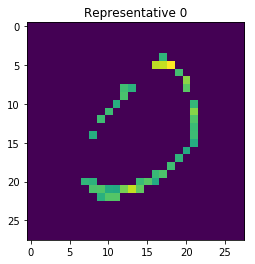

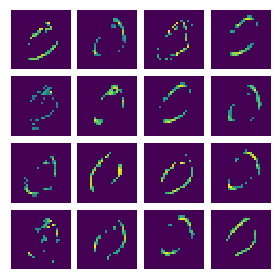

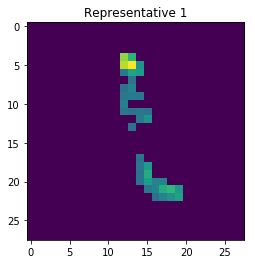

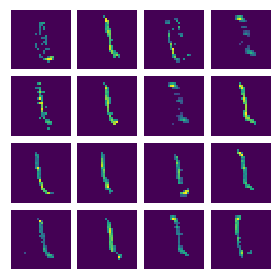

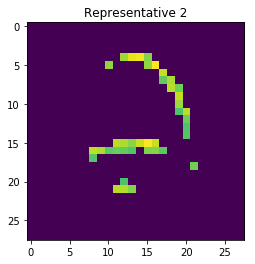

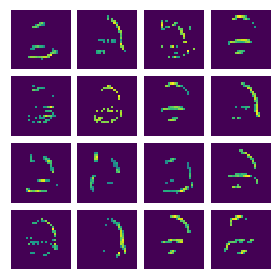

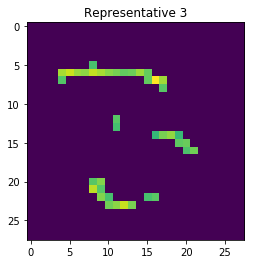

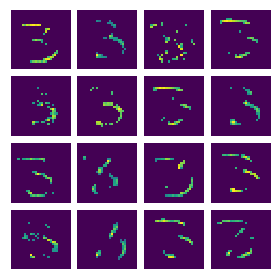

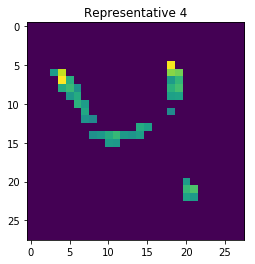

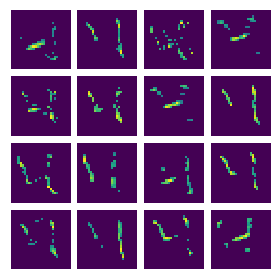

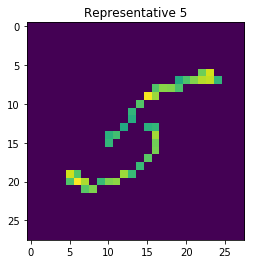

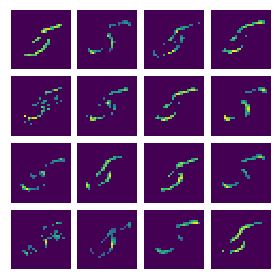

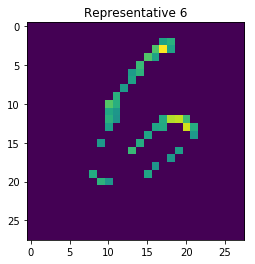

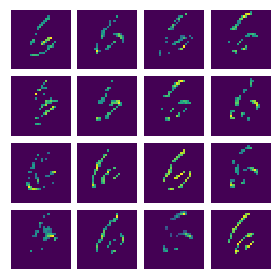

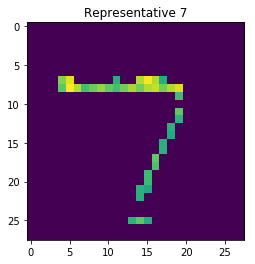

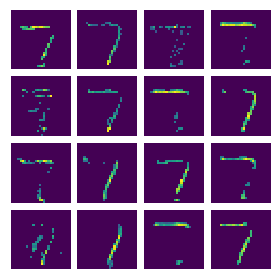

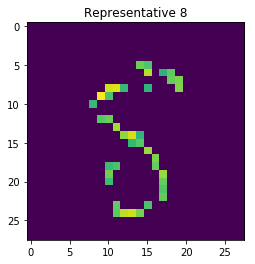

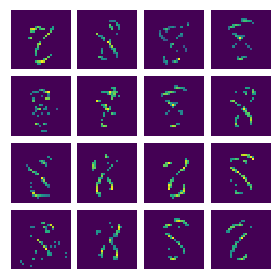

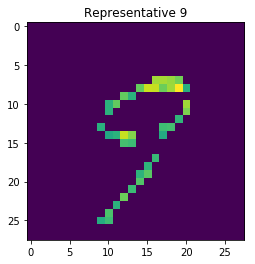

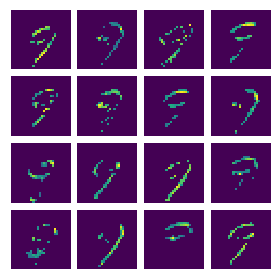

In [16]:
threshold = 95

for i, image in enumerate(representatives):
    
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
            
    cutoff = np.percentile(analysis.flatten(), threshold)
    analysis *= (analysis > cutoff)
    
    plt.figure()
    plt.imshow(analysis)
    plt.title("Representative {}".format(i))
    
    for idx, tensor in analyzer._reversed_tensors:
        if idx[0] == 1:
            fig, axes = plt.subplots(4, 4, figsize=(4,4))
            axes = axes.flatten()

            for j in range(16):
                analysis = tensor[...,j].squeeze()
                cutoff = np.percentile(analysis.flatten(), threshold)
                analysis *= (analysis > cutoff)
                axes[j].imshow(analysis)

            plt.setp(axes, xticks=[], yticks=[], frame_on=False)
            plt.tight_layout(h_pad=0, w_pad=0)

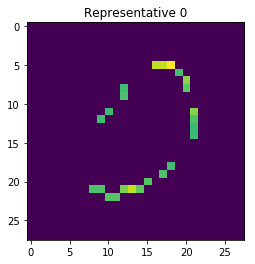

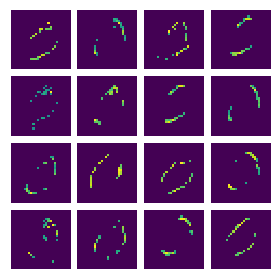

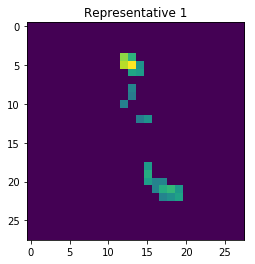

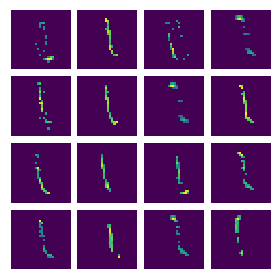

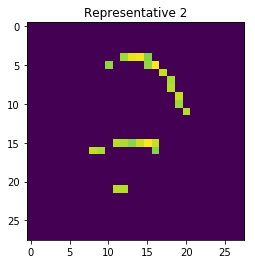

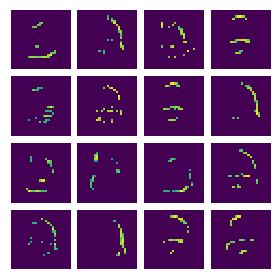

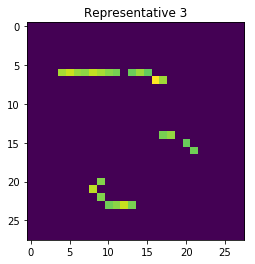

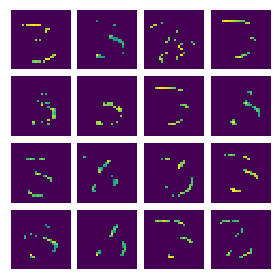

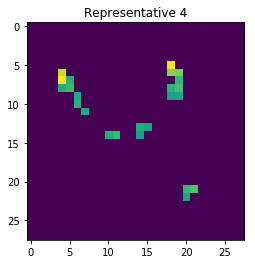

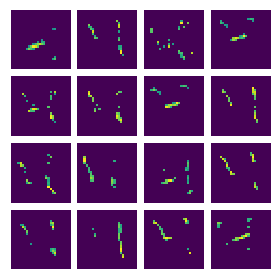

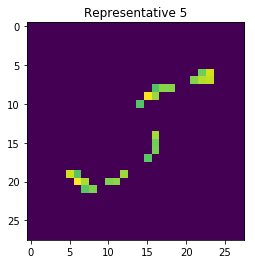

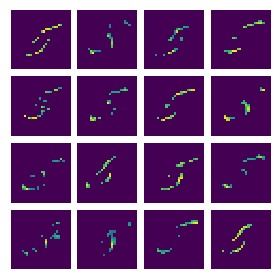

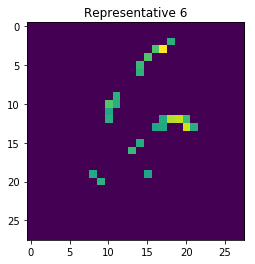

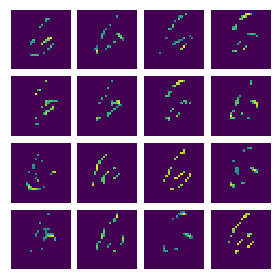

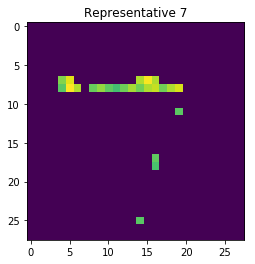

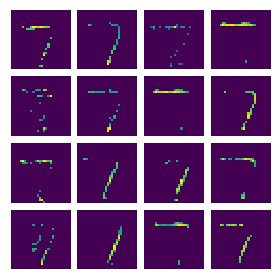

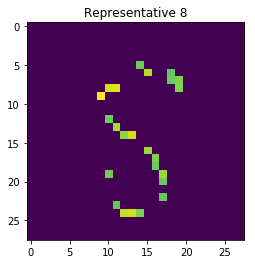

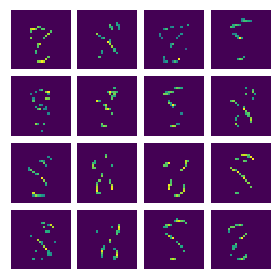

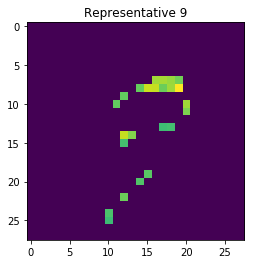

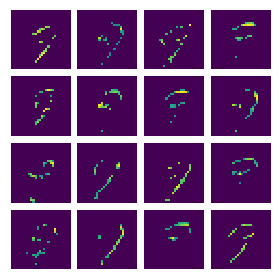

In [17]:
threshold = 97

for i, image in enumerate(representatives):
    
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
            
    cutoff = np.percentile(analysis.flatten(), threshold)
    analysis *= (analysis > cutoff)
    
    plt.figure()
    plt.imshow(analysis)
    plt.title("Representative {}".format(i))
    
    for idx, tensor in analyzer._reversed_tensors:
        if idx[0] == 1:
            fig, axes = plt.subplots(4, 4, figsize=(4,4))
            axes = axes.flatten()

            for j in range(16):
                analysis = tensor[...,j].squeeze()
                cutoff = np.percentile(analysis.flatten(), threshold)
                analysis *= (analysis > cutoff)
                axes[j].imshow(analysis)

            plt.setp(axes, xticks=[], yticks=[], frame_on=False)
            plt.tight_layout(h_pad=0, w_pad=0)

In [19]:
for idx, tensor in analyzer._reversed_tensors:
    print(idx, tensor.shape)

(-1, 0) (1,)
(-1, 0) (1, 28, 28)
(0, 0) (1, 28, 28, 1)
(1, 0) (1, 28, 28, 16)
(2, 0) (1, 12544)
(4, 0) (1, 10, 12544)
(5, 0) (1, 10)


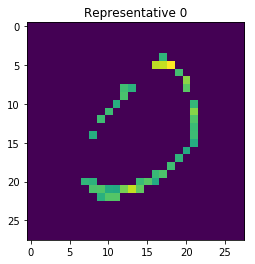

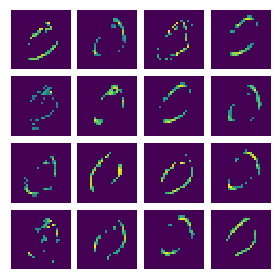

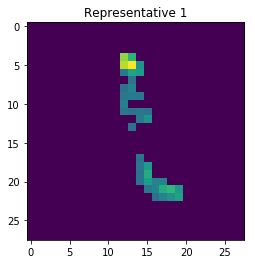

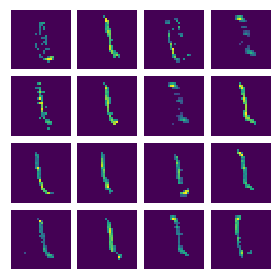

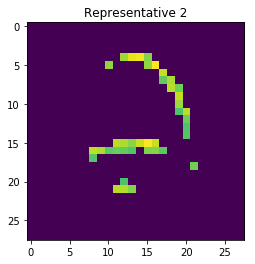

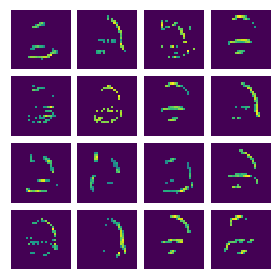

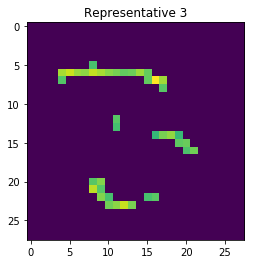

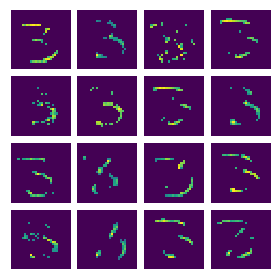

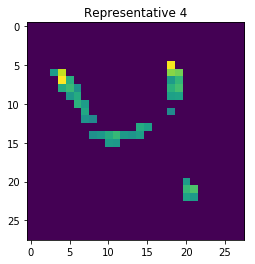

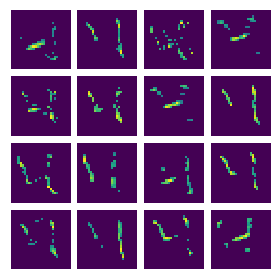

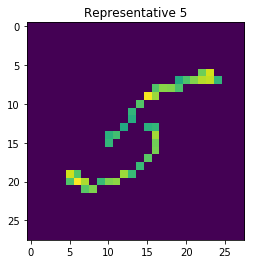

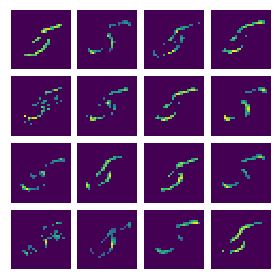

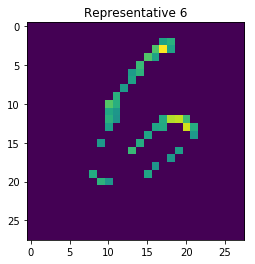

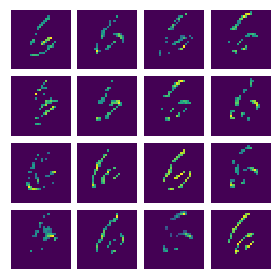

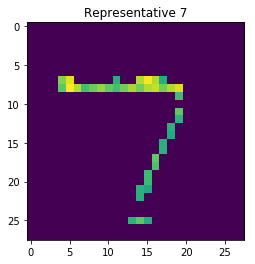

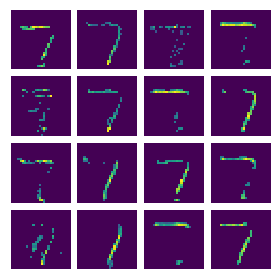

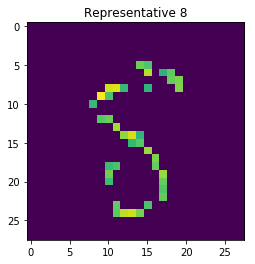

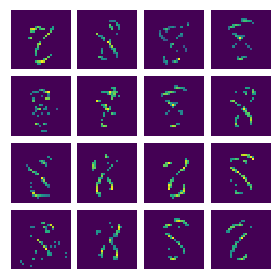

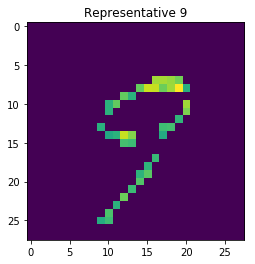

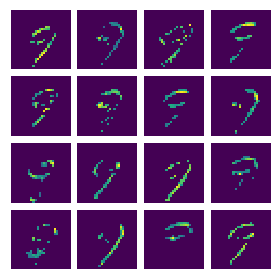

In [29]:
threshold = 95

for i, image in enumerate(representatives):
    
    image = image.reshape(1, 28, 28)
    analysis = analyzer.analyze(image, i).squeeze()
            
    cutoff = np.percentile(analysis.flatten(), threshold)
    analysis *= (analysis > cutoff)
    
    plt.figure()
    plt.imshow(analysis)
    plt.title("Representative {}".format(i))
    
    for idx, tensor in analyzer._reversed_tensors:
        if idx[0] == 1:
            fig, axes = plt.subplots(4, 4, figsize=(4,4))
            axes = axes.flatten()

            for j in range(16):
                analysis = tensor[...,j].squeeze()
                cutoff = np.percentile(analysis.flatten(), threshold)
                analysis *= (analysis > cutoff)
                axes[j].imshow(analysis)

            plt.setp(axes, xticks=[], yticks=[], frame_on=False)
            plt.tight_layout(h_pad=0, w_pad=0)